# FloPy shapefile export demo
The goal of this notebook is to demonstrate ways to export model information to shapefiles.
This example will cover:
* basic exporting of information for a model, individual package, or dataset
* custom exporting of combined data from different packages
* general exporting and importing of geographic data from other sources

In [1]:
% matplotlib inline
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

from flopy.utils.reference import SpatialReference
fm = flopy.modflow

In [2]:
# set the output directory
outdir = 'tmp'
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# load an existing model
model_ws = "../data/freyberg"
m = fm.Modflow.load("freyberg.nam", model_ws=model_ws, verbose=False,
                               check=False, exe_name="mfnwt")

In [3]:
m.get_package_list()

['DIS', 'BAS6', 'LPF', 'WEL', 'RIV', 'RCH', 'OC', 'PCG']

### set the model `SpatialReference`
the spatial reference describes where the grid is located in a projected coordinate system (e.g. UTM)

In [4]:
m.sr = SpatialReference(delr=m.dis.delr.array, delc=m.dis.delc.array, 
                        xul=273170, yul=5088657, # model upper left corner in UTM coordinates
                        epsg=26916, # UTM zone 16 north
                        lenuni=1 # model length units (1 for feet, 2 for meters (default))
                       )

In [5]:
m.sr

xul:273170; yul:5088657; rotation:0; proj4_str:+proj=utm +zone=16 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ; units:meters; lenuni:1; length_multiplier:0.3048

## Declarative export using attached `.export()` methods
#### Export the whole model to a single shapefile

In [6]:
fname = '{}/model.shp'.format(outdir)
m.export(fname)

wrote tmp/model.shp


'tmp/model.shp'

Text(0.5,1,'tmp/model.shp')

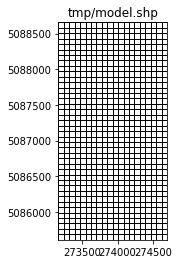

In [7]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = m.sr.get_extent()
pc = flopy.plot.plot_shapefile(fname, ax=ax, edgecolor='k', facecolor='none')
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(fname)

### Export a package to a shapefile

In [8]:
fname = '{}/wel.shp'.format(outdir)
m.wel.export(fname)

wrote tmp/wel.shp


### Export a FloPy list or array object

In [9]:
m.lpf.hk

In [10]:
fname = '{}/hk.shp'.format(outdir)
m.lpf.hk.export('{}/hk.shp'.format(outdir))

wrote tmp/hk.shp


Text(0.5,1,'tmp/hk.shp')

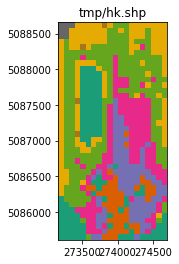

In [11]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = m.sr.get_extent()
a = m.lpf.hk.array.ravel()
pc = flopy.plot.plot_shapefile(fname, ax=ax, a=a)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(fname)

In [12]:
m.riv.stress_period_data

In [13]:
m.riv.stress_period_data.export('{}/riv_spd.shp'.format(outdir))

wrote tmp/riv_spd.shp


### MfList.export() exports the whole grid by default, regardless of the locations of the boundary cells
`sparse=True` only exports the boundary cells in the MfList

In [14]:
m.riv.stress_period_data.export('{}/riv_spd.shp'.format(outdir), sparse=True)

wrote tmp/riv_spd.shp


In [15]:
m.wel.stress_period_data.export('{}/wel_spd.shp'.format(outdir), sparse=True)

wrote tmp/wel_spd.shp


## Ad-hoc exporting using `recarray2shp`
* The main idea is to create a recarray with all of the attribute information, and a list of geometry features (one feature per row in the recarray)
* each geometry feature is an instance of the `Point`, `LineString` or `Polygon` classes in `flopy.utils.geometry`. The shapefile format requires all the features to be of the same type.
* We will use pandas dataframes for these examples because they are easy to work with, and then convert them to recarrays prior to exporting.


In [16]:
from flopy.export.shapefile_utils import recarray2shp

### combining data from different packages
write a shapefile of RIV and WEL package cells

In [17]:
wellspd = pd.DataFrame(m.wel.stress_period_data[0])
rivspd = pd.DataFrame(m.riv.stress_period_data[0])
spd = wellspd.append(rivspd)
spd.head()

,cond,flux,i,iface,j,k,rbot,stage
0,NaN,-0.00820,8,0.0,15,0,NaN,NaN
1,NaN,-0.00410,10,0.0,12,0,NaN,NaN
2,NaN,-0.00390,19,0.0,13,0,NaN,NaN
3,NaN,-0.00083,25,0.0,9,0,NaN,NaN
4,NaN,-0.00072,28,0.0,5,0,NaN,NaN


##### create a list of Polygon features from the cell vertices stored in the SpatialReference object

In [18]:
from flopy.utils.geometry import Polygon

vertices = m.sr.get_vertices(spd.i, spd.j)
polygons = [Polygon(vrt) for vrt in vertices]

##### write the shapefile

In [19]:
fname = '{}/bcs.shp'.format(outdir)
recarray2shp(spd.to_records(), geoms=polygons,
             shpname=fname,
             epsg=m.sr.epsg)

wrote tmp/bcs.shp


Text(0.5,1,'tmp/bcs.shp')

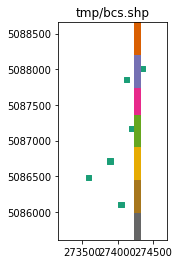

In [20]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = m.sr.get_extent()
pc = flopy.plot.plot_shapefile(fname, ax=ax)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(fname)

### exporting other data
Suppose we have some well data with actual locations that we want to export to a shapefile

In [21]:
welldata = pd.DataFrame({'wellID': np.arange(0, 10),
                         'q': np.random.randn(10)*100 - 1000,
                         'x_utm': np.random.rand(10)*1000 + m.sr.xul,
                         'y_utm': m.sr.yul - np.random.rand(10)*3000})
welldata.head()

,q,wellID,x_utm,y_utm
0,-841.470717,0,274116.771582,5.086501e+06
1,-1174.008690,1,273454.990331,5.087258e+06
2,-903.846959,2,273328.824921,5.086556e+06
3,-1055.262509,3,273397.235570,5.087742e+06
4,-969.162911,4,274166.289309,5.088636e+06


##### convert the x, y coorindates to point features and then export

In [22]:
from flopy.utils.geometry import Point
geoms = [Point(x, y) for x, y in zip(welldata.x_utm, welldata.y_utm)]

fname = '{}/wel_data.shp'.format(outdir)
recarray2shp(welldata.to_records(), geoms=geoms,
             shpname=fname,
             epsg=m.sr.epsg)

wrote tmp/wel_data.shp


Text(0.5,1,'tmp/wel_data.shp')

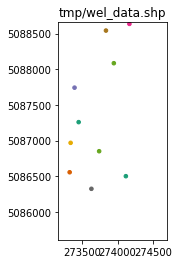

In [23]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = m.sr.get_extent()
pc = flopy.plot.plot_shapefile(fname, ax=ax, radius=25)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(fname)

### Adding attribute data to an existing shapefile
Suppose we have a GIS coverage representing the river in the riv package

In [24]:
from flopy.utils.geometry import LineString 

### make up a linestring shapefile of the river reaches
i, j = m.riv.stress_period_data[0].i, m.riv.stress_period_data[0].j
x0 = m.sr.xcentergrid[i[0], j[0]]
x1 = m.sr.xcentergrid[i[-1], j[-1]]
y0 = m.sr.ygrid[i[0], j[0]]
y1 = m.sr.ygrid[i[-1]+1, j[-1]+1]
x = np.linspace(x0, x1, m.nrow+1)
y = np.linspace(y0, y1, m.nrow+1)
l0 = zip(list(zip(x[:-1], y[:-1])), list(zip(x[1:], y[1:])))
lines = [LineString(l) for l in l0]

rivdata = pd.DataFrame(m.riv.stress_period_data[0])
rivdata['reach'] = np.arange(len(lines))
lines_shapefile = '{}/riv_reaches.shp'.format(outdir)
recarray2shp(rivdata.to_records(index=False), geoms=lines,
             shpname=lines_shapefile,
             epsg=m.sr.epsg)

wrote tmp/riv_reaches.shp


Text(0.5,1,'tmp/riv_reaches.shp')

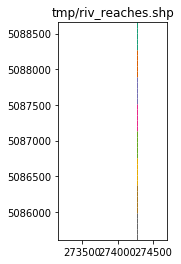

In [25]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = m.sr.get_extent()
pc = flopy.plot.plot_shapefile(lines_shapefile, ax=ax, radius=25)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(lines_shapefile)

#### read in the GIS coverage using `shp2recarray`
`shp2recarray` reads a shapefile into a numpy record array, which can easily be converted to a DataFrame

In [26]:
from flopy.export.shapefile_utils import shp2recarray

In [27]:
linesdata = shp2recarray(lines_shapefile)
linesdata = pd.DataFrame(linesdata)
linesdata.head()

,k,i,j,stage,cond,rbot,iface,reach,geometry
0,0,0,14,20.100000,0.05,20.00,0.0,0,<flopy.utils.geometry.LineString object at 0x1...
1,0,1,14,19.870001,0.05,19.75,0.0,1,<flopy.utils.geometry.LineString object at 0x1...
2,0,2,14,19.650000,0.05,19.50,0.0,2,<flopy.utils.geometry.LineString object at 0x1...
3,0,3,14,19.420000,0.05,19.25,0.0,3,<flopy.utils.geometry.LineString object at 0x1...
4,0,4,14,19.190001,0.05,19.00,0.0,4,<flopy.utils.geometry.LineString object at 0x1...


##### Suppose we have some flow information that we read in from the cell budget file

In [28]:
# make up some fluxes between the river and aquifer at each reach
q = np.random.randn(len(linesdata))+1
q

array([ 1.4639406 ,  0.19625729,  1.32430186, -0.63293107,  0.60307028,
        3.73706279,  2.0485505 ,  2.36943892,  1.2673445 , -0.23649179,
        0.50172979,  0.40727811,  2.95133494, -0.43792951,  1.5946215 ,
       -0.35319615,  1.44369336,  1.80224914,  2.74881664, -0.03675662,
        1.32310316,  1.44646379,  1.2650691 ,  1.420417  , -0.49485504,
        0.6423664 ,  2.49564081, -0.17548761, -0.20251342,  1.66930163,
        0.86407385,  1.4519291 ,  0.17132449,  1.28426709,  1.87675642,
        1.41333912,  1.65489766, -0.79699607,  0.6824513 ,  1.06637135])

##### Add reachs fluxes and cumulative flow to lines DataFrame

In [29]:
linesdata['qreach'] = q
linesdata['qstream'] = np.cumsum(q)

In [30]:
recarray2shp(linesdata.drop('geometry', axis=1).to_records(), 
             geoms=linesdata.geometry,
             shpname=lines_shapefile,
             epsg=m.sr.epsg)

wrote tmp/riv_reaches.shp


Text(0.5,1,'tmp/riv_reaches.shp')

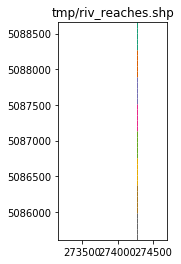

In [31]:
ax = plt.subplot(1, 1, 1, aspect='equal')
extents = m.sr.get_extent()
pc = flopy.plot.plot_shapefile(lines_shapefile, ax=ax, radius=25)
ax.set_xlim(extents[0], extents[1])
ax.set_ylim(extents[2], extents[3])
ax.set_title(lines_shapefile)